In [1]:
import ott
import matplotlib.pyplot as plt
import numpy as np
import optax
import jax
import jax.numpy as jnp
import scanpy as sc
from sklearn.preprocessing import StandardScaler
from entot.models.model import OTFlowMatching
from entot.nets.nets import MLP_vector_field, Bridge_MLP_mean
from entot.plotting.plots import plot_1D_balanced

/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/equinox/_ad.py:753: UserWarning: As of Equinox 0.10.7, `equinox.filter_custom_vjp.defvjp` is deprecated in favour of `.def_fwd` and `.def_bwd`. This new API supports symbolic zeros, which allow for more efficient autodifferentiation rules. In particular:
- the fwd and bwd functions take an extra `perturbed` argument, which     indicates which primals actually need a gradient. You can use this     to skip computing the gradient for any unperturbed value. (You can     also safely just ignore this if you wish.)
- `None` was previously passed to indicate a symbolic zero gradient for     all objects that weren't inexact arrays, but all inexact arrays     always had an array-valued gradient. Now, `None` may also be passed     to indicate that an inexact array has a symbolic zero gradient.
  warnings.warn(
2023-08-30 16:47:07.808935: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not 

In [2]:
adata = sc.read("/lustre/groups/ml01/workspace/moscot_paper/pancreas/pancreas_multiome_2022_processed.h5ad")

In [3]:
adata = adata[~adata.obs["celltype"].isin(["Imm. Acinar", "Mat. Acinar"])]

/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


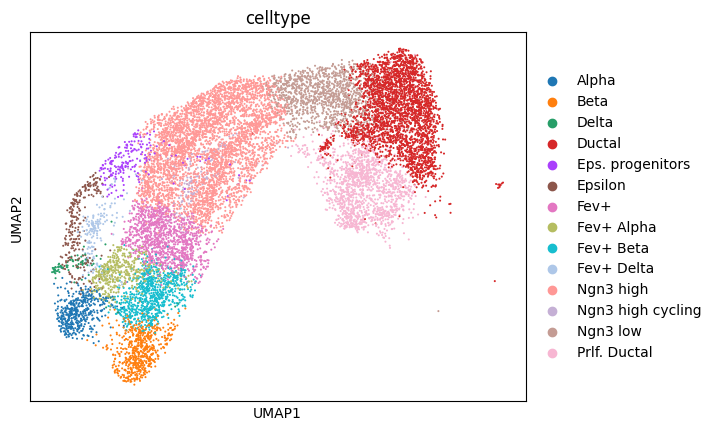

In [4]:
sc.pl.umap(adata, color="celltype")

In [5]:
sc.pp.pca(adata, n_comps=30)
adata.obsm["X_pca_scaled"] = StandardScaler().fit_transform(adata.obsm["X_pca"])

In [6]:
source_adata = adata[adata.obs["sample"]=="14.5"]
target_adata = adata[adata.obs["sample"]=="15.5"]
source = source_adata.obsm["X_pca_scaled"]
target = target_adata.obsm["X_pca_scaled"]


In [7]:
neural_net = MLP_vector_field(30, 128, 128, 128)
bridge_net = Bridge_MLP_mean(30, 128, 128)

In [8]:
ot_solver=ott.solvers.linear.sinkhorn.Sinkhorn()

otfm = OTFlowMatching(neural_net, bridge_net=bridge_net, ot_solver=ot_solver, epsilon=1e-3, input_dim=30, output_dim=30, iterations=5_000, k_noise_per_x=1)

2023-08-30 16:50:54.548713: W external/xla/xla/service/gpu/nvptx_compiler.cc:698] The NVIDIA driver's CUDA version is 12.1 which is older than the ptxas CUDA version (12.2.128). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


In [9]:
otfm(source, target, 1024, 1024)

  0%|          | 0/5000 [00:00<?, ?it/s]


StopIteration: 

In [30]:
pushed,_, resc = otfm.transport(source, seed=2)

In [9]:
bdata = adata.copy()
bdata.obsm["X_pca_result"] = np.concatenate((pushed[0,...], target), axis=0)

In [10]:
sc.pp.neighbors(bdata, use_rep="X_pca_result")

/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/icb/dominik.klein/mambaforge/envs/

In [11]:
sc.tl.umap(bdata)

/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/icb/dominik.klein/mambaforge/envs/entot_pip/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:392: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


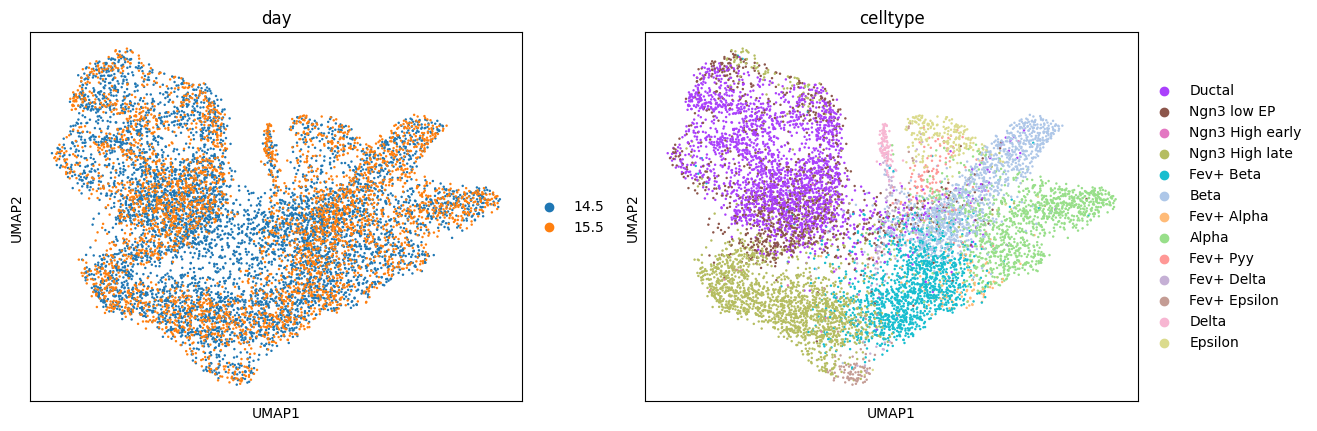

In [12]:
sc.pl.umap(bdata, color=["day", "celltype"])

In [31]:
from typing import Tuple, Callable, Union, List, Optional
import scipy.sparse as sp
import jax.numpy as jnp
import jax
import pandas as pd

def get_nearest_neighbors(
    input_batch: jnp.ndarray, target: jnp.ndarray, k: int = 30
) -> Tuple[jnp.ndarray, jnp.ndarray]:
    """Get the k nearest neighbors of the input batch in the target."""
    if target.shape[0] < k:
        raise ValueError(f"k is {k}, but must be smaller or equal than {target.shape[0]}.")
    pairwise_euclidean_distances = jnp.sqrt(jnp.sum((input_batch - target) ** 2, axis=-1))
    negative_distances, indices = jax.lax.top_k(-1 * pairwise_euclidean_distances, k=k)
    return -1 * negative_distances, indices

def project_transport_matrix(  
        predicted_tgt_cells: jnp.ndarray,
        tgt_cells: jnp.ndarray,
        batch_size: int = 1024,
        k: int = 1,
    ) -> sp.csr_matrix:
        """Project Neural OT map onto cells."""

        get_knn_fn = jax.vmap(get_nearest_neighbors, in_axes=(0, None, None))
        row_indices: Union[jnp.ndarray, List[jnp.ndarray]] = []
        column_indices: Union[jnp.ndarray, List[jnp.ndarray]] = []
        distances_list: Union[jnp.ndarray, List[jnp.ndarray]] = []
        for index in range(0, len(predicted_tgt_cells), batch_size):
            _, indices = get_knn_fn(predicted_tgt_cells[index : index + batch_size], tgt_cells, k)
            column_indices.append(indices.flatten())
            row_indices.append(
                jnp.repeat(jnp.arange(index, index + min(batch_size, len(predicted_tgt_cells) - index)), min(k, len(tgt_cells)))
            )
        ri = jnp.concatenate(row_indices)
        ci = jnp.concatenate(column_indices)
        mat = np.zeros((len(ri), len(tgt_cells)))
        mat[ri,ci] = 1.0
        return mat

def aggregate_transport_matrix(adata_source, adata_target, tmat, aggregation_key = "celltype", forward = True):
    df_source = adata_source.obs[aggregation_key]
    df_target = adata_target.obs[aggregation_key]

    annotations_source = adata_source.obs[aggregation_key].cat.categories
    annotations_target = adata_target.obs[aggregation_key].cat.categories

    tm = pd.DataFrame(
        np.zeros((len(annotations_source), len(annotations_target))),
        index=annotations_source,
        columns=annotations_target,
    )
    
    for annotation_src in annotations_source:
        for annotation_tgt in annotations_target:
            tm.loc[annotation_src, annotation_tgt] = tmat[
                np.ix_((df_source == annotation_src).squeeze(), (df_target == annotation_tgt).squeeze())
            ].sum()
    return tm.div(tm.sum(axis=int(forward)), axis=int(not forward))

In [32]:
tm = project_transport_matrix(pushed[0,...], target)
agg_tm = aggregate_transport_matrix(source_adata, target_adata, tm, forward=False)

In [33]:
agg_tm

,Ductal,Ngn3 low EP,Ngn3 High late,Fev+ Beta,Beta,Fev+ Alpha,Alpha,Fev+ Pyy,Fev+ Delta,Fev+ Epsilon,Delta,Epsilon
Ductal,0.662891,0.446461,0.015561,0.009162,0.017405,0.000000,0.006410,0.000000,0.000000,0.000000,0.000000,0.008547
Ngn3 low EP,0.278317,0.470054,0.035217,0.011780,0.020570,0.000000,0.001603,0.000000,0.021739,0.000000,0.000000,0.000000
Ngn3 High early,0.002157,0.000000,0.012285,0.001309,0.001582,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
Ngn3 High late,0.039374,0.067151,0.754300,0.018325,0.001582,0.000000,0.000000,0.000000,0.000000,0.119048,0.000000,0.000000
Fev+ Beta,0.009709,0.009074,0.167076,0.735602,0.104430,0.117647,0.019231,0.000000,0.130435,0.142857,0.000000,0.000000
Beta,0.003776,0.003630,0.002457,0.068063,0.762658,0.000000,0.056090,0.033333,0.065217,0.023810,0.000000,0.000000
Fev+ Alpha,0.000539,0.001815,0.000819,0.089005,0.006329,0.529412,0.028846,0.000000,0.021739,0.000000,0.000000,0.000000
Alpha,0.002697,0.001815,0.000819,0.048429,0.074367,0.352941,0.844551,0.133333,0.043478,0.000000,0.027778,0.059829
Fev+ Pyy,0.000539,0.000000,0.000000,0.007853,0.003165,0.000000,0.040064,0.633333,0.086957,0.000000,0.027778,0.222222
Fev+ Delta,0.000000,0.000000,0.000819,0.009162,0.006329,0.000000,0.001603,0.100000,0.521739,0.047619,0.111111,0.017094


In [35]:
source_adata.obs["celltype"].cat.categories

Index(['Ductal', 'Ngn3 low EP', 'Ngn3 High early', 'Ngn3 High late',
       'Fev+ Beta', 'Beta', 'Fev+ Alpha', 'Alpha', 'Fev+ Pyy', 'Fev+ Delta',
       'Fev+ Epsilon', 'Delta', 'Epsilon'],
      dtype='object')

In [43]:
adata = sc.read("/lustre/groups/ml01/workspace/moscot_paper/pancreas/pancreas_multiome_2022_processed.h5ad")

In [44]:
adata.obs["celltype"].cat.categories

Index(['Alpha', 'Beta', 'Delta', 'Ductal', 'Eps. progenitors', 'Epsilon',
       'Fev+', 'Fev+ Alpha', 'Fev+ Beta', 'Fev+ Delta', 'Imm. Acinar',
       'Mat. Acinar', 'Ngn3 high', 'Ngn3 high cycling', 'Ngn3 low',
       'Prlf. Ductal'],
      dtype='object')

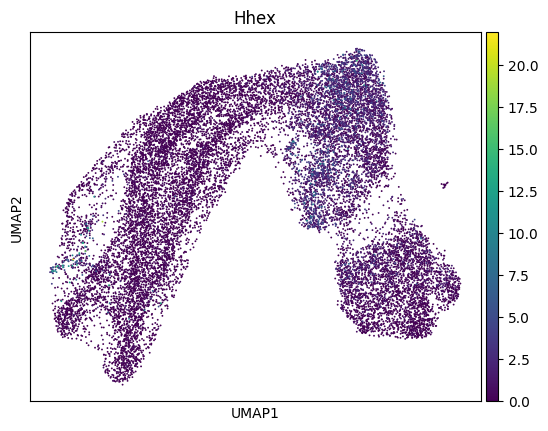

In [45]:
sc.pl.umap(adata, color="Hhex")

In [26]:
samples = jnp.array(res)
vars = jnp.var(samples, axis=0)
vars_summed = jnp.sum(vars, axis=1)

In [27]:
fill = np.empty(len(target))[:, None]
fill[:] = np.nan
bdata.obs["var"] = np.asarray(np.concatenate((vars_summed[:, None], fill)))

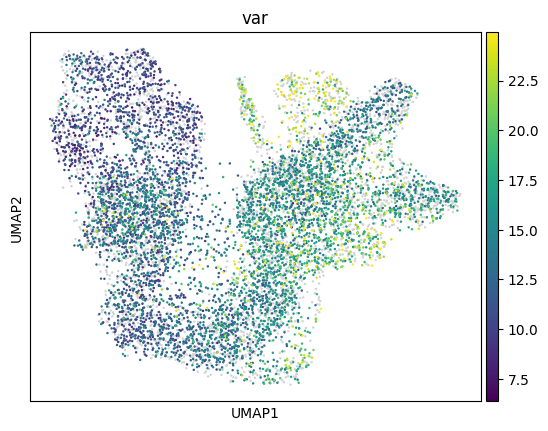

In [28]:
sc.pl.umap(bdata, color="var", vmax="p98")

In [29]:
bdata.obs[["celltype", "var"]].groupby("celltype").mean()

,var
celltype,
Ductal,11.765286
Ngn3 low EP,12.517499
Ngn3 High early,16.767558
Ngn3 High late,13.217741
Fev+ Beta,15.468299
Beta,14.907773
Fev+ Alpha,17.415613
Alpha,18.070363
Fev+ Pyy,21.405229


In [31]:
from typing import Callable, Optional, Tuple, Union, List
import scipy.sparse as sp


def get_nearest_neighbors(
    input_batch: jnp.ndarray, target: jnp.ndarray, k: int = 30
) -> Tuple[jnp.ndarray, jnp.ndarray]:
    """Get the k nearest neighbors of the input batch in the target."""
    if target.shape[0] < k:
        raise ValueError(f"k is {k}, but must be smaller or equal than {target.shape[0]}.")
    pairwise_euclidean_distances = jnp.sqrt(jnp.sum((input_batch - target) ** 2, axis=-1))
    negative_distances, indices = jax.lax.top_k(-1 * pairwise_euclidean_distances, k=k)
    return -1 * negative_distances, indices

def project_transport_matrix(  # type:ignore[override]
        transport_map: Callable[[jnp.ndarray], jnp.ndarray],
        src_cells: jnp.ndarray,
        tgt_cells: jnp.ndarray,
        batch_size: int = 1024,
        k: int = 1,
        length_scale: Optional[float] = None,
    ) -> sp.csr_matrix:
        """Project Neural OT map onto cells."""

        get_knn_fn = jax.vmap(get_nearest_neighbors, in_axes=(0, None, None))
        row_indices: Union[jnp.ndarray, List[jnp.ndarray]] = []
        column_indices: Union[jnp.ndarray, List[jnp.ndarray]] = []
        distances_list: Union[jnp.ndarray, List[jnp.ndarray]] = []
        for index in range(0, len(src_cells), batch_size):
            distances, indices = get_knn_fn(transport_map(src_cells[index : index + batch_size]), tgt_cells, k)
            distances_list.append(float(distances.flatten()>1))
            column_indices.append(indices.flatten())
            row_indices.append(
                jnp.repeat(jnp.arange(index, index + min(batch_size, len(src_cells) - index)), min(k, len(tgt_cells)))
            )
        distances = jnp.concatenate(distances_list)
        row_indices = jnp.concatenate(row_indices)
        column_indices = jnp.concatenate(column_indices)
        tm = sp.csr_matrix((distances, (row_indices, column_indices)), shape=[len(src_cells), len(tgt_cells)])
        return tm

In [ ]:
project_transport_matrix(

In [ ]:
adata_early = adata[adata.obs["sample"]=="E14.5"]
adata_late = adata[adata.obs["sample"]=="E15.5"]

df_res = pd.DataFrame(index=adata_early.obs["celltype"].cat.categories)
for ct in adata_late.obs["celltype"].cat.categories:
    cols_cell_type = adata_late[adata_late.obs["celltype"] == ct].obs.index
    for ct2 in adata_early.obs["celltype"].cat.categories:
        index_cell_type = adata_early[adata_early.obs["celltype"] == ct2].obs.index
        df_res.loc[ct2, ct] = tm_df.loc[index_cell_type, cols_cell_type].sum().sum()